# How Multilingual is Multilingual BERT?
Goal: fine-tune a pretrained language model on Part Of Speech tagging in a **multilingual** context.

The challenge of this notebook is the preprocessing. We will have to deal with tokenization mismatches between UD tokenization and MBert tokenization.

Steps:
1) data preprocessing
2) train and evaluate a multilingual PoS tagger by fine-tuning mBERT
      *   Evaluation of the performance of a PoS tagger fine-tuned on a given language and comparison with the performance of a PoS tagger trained only on this language ;
      *   Evaluation on a language B of the performance of a PoS tagger fine-tuned on a language A


Used dataset: Universal Dependencies Project (collection of treebanks with consistent annotations across different human languages). Problem: the UD projects are stored in the conllu format, notoriously difficult to parse.


### Requirements

In [1]:
#! pip install transformers
#! pip install spacy
! pip install conllu
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00


### Imports

In [2]:
from conllu import parse
from collections import Counter
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict
import numpy as np
import gc, torch
from collections.abc import Callable
from evaluate import load
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from itertools import product

### Label distribution in fr_sequoia-ud-test.conllu

In [3]:
dataset_name = "fr_sequoia-ud.conllu"

def load_conllu(filename: str) -> tuple[str, str] :

  for sentence in parse(open(filename, "rt", encoding="utf-8").read()):
    tokenized_words = [token["form"] for token in sentence]
    gold_tags = [token["upos"] for token in sentence]
    yield tokenized_words, gold_tags

corpus = list(load_conllu(dataset_name))
print("Tokenized sentence:" , corpus[0][0], '\nPOS-tagging       :', corpus[0][1])
print(corpus[:4])

Tokenized sentence: ['Gutenberg'] 
POS-tagging       : ['PROPN']
[(['Gutenberg'], ['PROPN']), (['Cette', 'exposition', 'nous', 'apprend', 'que', 'dès', 'le', 'XIIe', 'siècle', ',', 'à', 'Dammarie-sur-Saulx', ',', 'entre', 'autres', 'sites', ',', 'une', 'industrie', 'métallurgique', 'existait', '.'], ['DET', 'NOUN', 'PRON', 'VERB', 'SCONJ', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'ADJ', 'NOUN', 'PUNCT', 'DET', 'NOUN', 'ADJ', 'VERB', 'PUNCT']), (['à', 'peu', 'près', 'au', 'à', 'le', 'même', 'moment', 'que', 'Gutenberg', 'inventait', "l'", 'imprimerie', ',', 'Gillet', 'Bonnemire', 'créait', 'en', '1450', 'la', 'première', 'forge', 'à', 'Saint-Dizier', ',', 'à', "l'", 'actuel', 'emplacement', 'du', 'de', 'le', 'CHS', '.'], ['ADP', 'ADV', 'ADV', '_', 'ADP', 'DET', 'ADJ', 'NOUN', 'SCONJ', 'PROPN', 'VERB', 'DET', 'NOUN', 'PUNCT', 'PROPN', 'PROPN', 'VERB', 'ADP', 'NUM', 'DET', 'ADJ', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', '_', 'ADP', 'DET', 

In [4]:
def flatten_list(l: list[list]) -> list:
  return [i for s in l for i in s]

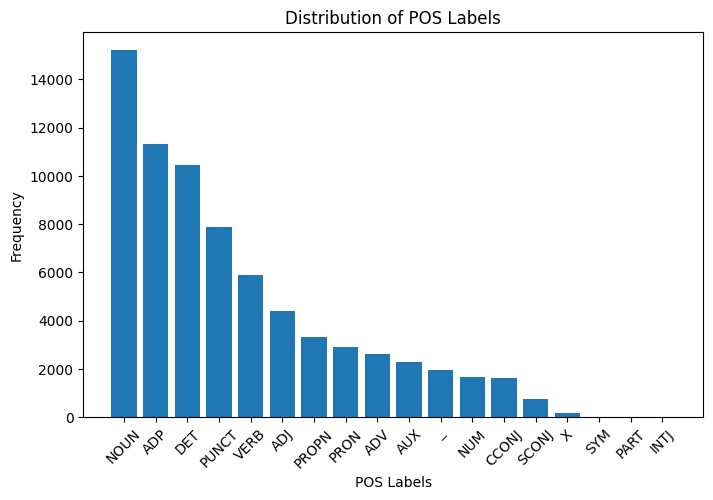

In [5]:
POS_labels_2D_list = [list_POS for sentence, list_POS in corpus]
# flatten the list:
POS_labels = flatten_list(POS_labels_2D_list)

label_counts = Counter(POS_labels)
# Sort by frequency (descending)
labels, counts = zip(*label_counts.most_common())
# Plot distribution
plt.figure(figsize=(8, 5))
plt.bar(labels, counts)
plt.xlabel("POS Labels")
plt.ylabel("Frequency")
plt.title("Distribution of POS Labels")
plt.xticks(rotation=45)
plt.show()

"-" is a label for multiword tokens. Multiword tokens make labelling across languages more universal. Let's see what they are.

In [6]:
def get_contraction2multiwords2POS_tag(filename: str) -> tuple[dict[str, list[str]], dict[str, str]] :
  contraction2multiwords = {}
  contraction2POS_tag = {}
  for sentence in parse(open(filename, "rt", encoding="utf-8").read()):
    for i, token in enumerate(sentence):
      #print(token['id'])
      if "-" in str(token['id']):
        ids = [id for id in token['id'] if id != "-"]
        multiwords = [sentence[i+j]['form'].lower() for j in range(1, len(ids)+1)]
        POS_tags = [sentence[i+j]['upos'] for j in range(1, len(ids)+1)]
        contraction2multiwords[token['form'].lower()] = multiwords
        contraction2POS_tag[token['form'].lower()] = "+".join(POS_tags)
  return contraction2multiwords, contraction2POS_tag

contraction2multiwords, contraction2POS_tag = get_contraction2multiwords2POS_tag(dataset_name)
print(contraction2multiwords)
print(contraction2POS_tag)

{'au': ['à', 'le'], 'du': ['de', 'le'], 'des': ['de', 'les'], 'aux': ['à', 'les'], 'duquel': ['de', 'lequel'], 'auxquels': ['à', 'lesquels'], 'desdites': ['de', 'lesdites'], 'auxquelles': ['à', 'lesquelles']}
{'au': 'ADP+DET', 'du': 'ADP+DET', 'des': 'ADP+DET', 'aux': 'ADP+DET', 'duquel': 'ADP+PRON', 'auxquels': 'ADP+PRON', 'desdites': 'ADP+DET', 'auxquelles': 'ADP+PRON'}


A word can contain (a) space(s), we'd better remove them.

In [7]:
def get_tokens_with_spaces(corpus: list[tuple[list[str], list[str]]]) -> list[str]:
  list_words = flatten_list([corpus[i][0] for i in range(len(corpus))])
  tokens_with_space = [token.lower() for token in list_words if ' ' in token]
  return tokens_with_space

tokens_with_space = get_tokens_with_spaces(corpus)
tokens_with_space

['20 000',
 '14 000',
 '6 000',
 '13 819',
 '13 819',
 '6 000',
 '10 000',
 '50 000',
 '125 000',
 '8 000',
 '2 127',
 '1 065',
 '1 062',
 '50 000',
 '125 000',
 '3 862',
 '3 852',
 '3 862',
 '3 852',
 '7 736',
 '7 736',
 '1 000',
 '1 500',
 '1 200',
 '1 246',
 '2 127',
 '50 000',
 '125 000',
 '1 000',
 '1 500',
 '1 200',
 '1 000',
 '50 000',
 '125 000',
 '500 000',
 '800 000',
 '80 000',
 '5 000',
 '70 000',
 '4 000',
 '7 000',
 '10 000',
 '111 547',
 '67 025',
 '15 000',
 '2 000',
 '2 000',
 '25 000',
 '19 000',
 '2 914571 14 3',
 '100 000',
 '15 000',
 '190 500',
 '260 000',
 '108 000',
 '50 000',
 '46 000',
 '50 000',
 '3 092',
 '80 000',
 '50 000',
 '10 000',
 '850 000',
 '17 600',
 '1 500']

In [8]:
def clean_corpus_spaces(corpus: list[tuple[list[str], list[str]]]):
  """
  Remove spaces from corpus.
  """
  return [([token.replace(" ", "") for token in tokens], tags) for tokens, tags in corpus]
corpus = clean_corpus_spaces(corpus)

# MBert model

### MBert tokenization

Reminder: mBERT (as well a the original BERT model) uses a tokenization in subword units. Frequent
words remain untouched, but infrequent words are split in smaller bits (which sometimes correspond to affixes). In addition, punctuation is split at the character level. For mBERT, subword tokens are prefixed with ##.

Subword tokenization keeps the vocabulary manageable, since biulding the vocablurary for diffeent languages would be prohibitively large. The other benefit is that it handles words unseen in training.

### MBert tokenization VS UD tokenization
Since we will train MBert to predict POS tags as it done in Sequoia, we need to compare how the tokenization is done in Sequoia VS by MBert.

In [9]:
text_to_compare = "Y a-t-il des circonstances dans lesquelles la Commission chercherait à utiliser le vote à la majorité qualifiée pour l'un de ces sujets ?"
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
# show the resulting tokenization
print("Bert tokenization:", tokenizer.tokenize(text_to_compare))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Bert tokenization: ['Y', 'a', '-', 't', '-', 'il', 'des', 'ci', '##rco', '##nst', '##ances', 'dans', 'lesquelles', 'la', 'Commission', 'cherche', '##rait', 'à', 'utiliser', 'le', 'vote', 'à', 'la', 'majorité', 'qualifié', '##e', 'pour', 'l', "'", 'un', 'de', 'ces', 'sujets', '?']


In [10]:
def compare_UD_tokenization(filename: str, text_to_compare: str):

  for sentence in parse(open(filename, "rt", encoding="utf-8").read()):
    #print(sentence.metadata.get("text"))
    if sentence.metadata.get("text") == text_to_compare:
      tokenized_words = [token["form"] for token in sentence]
      yield tokenized_words

tokenized_words_UD = list(compare_UD_tokenization(dataset_name, text_to_compare))
tokenized_words_UD

[['Y',
  'a',
  '-t',
  '-il',
  'des',
  'circonstances',
  'dans',
  'lesquelles',
  'la',
  'Commission',
  'chercherait',
  'à',
  'utiliser',
  'le',
  'vote',
  'à',
  'la',
  'majorité',
  'qualifiée',
  'pour',
  "l'",
  'un',
  'de',
  'ces',
  'sujets',
  '?']]

This tokenization mismatch between the BertTokenizer and the UD convention is a problem since POS tagging assigns one tag per word whereas mBERT splits words into multiple tokens. In other words, there will be a problem of consistency for mBERT since the model will have sometimes to assign one tag per token (when the token is a word), sometimes one same tag for several tokens (when the sequence of tokens is a sequence of subwords). For the latter, two options are to be considered: either assigning the POS to the first subword either assigning the same POS to all subwords of a given word.

Besides, UD analysis decomposes the morphological contraction of a word. For example, "au" is the contraction of "à" and "le. In UD analysis, "au" is tagged "_", but the following "à" is tagged "ADP" and "le" is tagged "DET". MBERT does not decompose "au" into subwords.

In conclusion, there is no pair (entry token, gold tag) for each example. I suggest therefore this solution:

*   Multiword tokens that have to be split according to UD annotation guidelines are kept unchanged and labelled by a new label made of the concatenation of all the label of its
token. For instance the French word 'au' is not decomposed into à (an ADP) and le (a DET) but labelled by ADP+DET ;
*   For UD tokens that are subtokenized into several units by mBERT, we choose to align the tag with the first subtoken of the word and convert the rest to the prediction of a special <pad> tag. The <pad> tag will have an other role when batching sentences together and we will ignore it when evaluating the accuracy of the predicted tags.

Let's implement a function that would apply the principles described above:

In [11]:
def update_UD_tokenization_and_POS_tags(UD_tokenization: list[str], UD_original_labels: list[str], contraction2multiwords: dict[str, list[str]], contraction2POS_tag: dict[str, str]) -> tuple[list[str], list[str]]:
  #print("update_UD_tokenization_and_POS_tags()")
  #print("UD_tokenization", UD_tokenization)
  for j, token in enumerate(UD_tokenization):
    normalized_token = token.lower()
    if normalized_token in contraction2multiwords and j+len(contraction2multiwords[normalized_token]) < len(UD_tokenization):
      token_match = [normalized_token] + contraction2multiwords[normalized_token]
      count_match = 0
      #print("token_match", token_match)
      for i, word in enumerate(token_match):
        #print("i", i, "word", word)
        #print(UD_tokenization)
        #print("len(UD_tokenization)", len(UD_tokenization), "j", j, "i", i)
        if UD_tokenization[j+i].lower() == word:
          count_match += 1
      if count_match == len(token_match):
        #print("count_match == len(token_match)")
        UD_original_labels[j] = contraction2POS_tag[normalized_token]
        for _ in range(len(contraction2multiwords[normalized_token])):
          #print("POP")
          UD_tokenization.pop(j+i-1)
          UD_original_labels.pop(j+i-1)
  return UD_tokenization, UD_original_labels

# sanity check #1
UD_tokenization = ["Revenons", "-en", "aux", "à", "les", "choses", "essentielles", "."]
UD_original_labels = ["VERB", "PRON", "_", "ADP", "DET", "NOUN", "ADJ", "PUNCT"]
UD_expected_tokenziation = ["Revenons", "-en", "aux", "choses", "essentielles", "."]
UD_expected_labels = ["VERB", "PRON", "ADP+DET", "NOUN", "ADJ", "PUNCT"]

updated_tok, updated_POS = update_UD_tokenization_and_POS_tags(UD_tokenization, UD_original_labels, contraction2multiwords, contraction2POS_tag)
assert updated_tok == UD_expected_tokenziation
assert updated_POS == UD_expected_labels

# sanity check #2
UD_tokenization = ['à', 'peu', 'près', 'au', 'à', 'le', 'même', 'moment', 'que', 'Gutenberg', 'inventait', "l'", 'imprimerie', ',', 'Gillet', 'Bonnemire', 'créait', 'en', '1450', 'la', 'première', 'forge', 'à', 'Saint-Dizier', ',', 'à', "l'", 'actuel', 'emplacement', 'du', 'de', 'le', 'CHS', '.']
UD_expected_tokenziation = ['à', 'peu', 'près', 'au', 'même', 'moment', 'que', 'Gutenberg', 'inventait', "l'", 'imprimerie', ',', 'Gillet', 'Bonnemire', 'créait', 'en', '1450', 'la', 'première', 'forge', 'à', 'Saint-Dizier', ',', 'à', "l'", 'actuel', 'emplacement', 'du', 'CHS', '.']
UD_original_labels = ['ADP', 'ADV', 'ADV', '_', 'ADP', 'DET', 'ADJ', 'NOUN', 'SCONJ', 'PROPN', 'VERB', 'DET', 'NOUN', 'PUNCT', 'PROPN', 'PROPN', 'VERB', 'ADP', 'NUM', 'DET', 'ADJ', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', '_', 'ADP', 'DET', 'PROPN', 'PUNCT']
UD_expected_labels = ['ADP', 'ADV', 'ADV', 'ADP+DET', 'ADJ', 'NOUN', 'SCONJ', 'PROPN', 'VERB', 'DET', 'NOUN', 'PUNCT', 'PROPN', 'PROPN', 'VERB', 'ADP', 'NUM', 'DET', 'ADJ', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'ADP+DET', 'PROPN', 'PUNCT']
updated_tok, updated_POS = update_UD_tokenization_and_POS_tags(UD_tokenization, UD_original_labels, contraction2multiwords, contraction2POS_tag)
assert updated_tok == UD_expected_tokenziation
assert updated_POS == UD_expected_labels

# sanity check #3
UD_tokenization = ['Au', 'À', 'le', 'cours', 'de', 'la', 'cérémonie', "d'", 'inauguration', '.']
UD_expected_tokenziation = ['Au', 'cours', 'de', 'la', 'cérémonie', "d'", 'inauguration', '.']
UD_original_labels = ['_', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'PUNCT']
UD_expected_labels = ['ADP+DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'PUNCT']
updated_tok, updated_POS = update_UD_tokenization_and_POS_tags(UD_tokenization, UD_original_labels, contraction2multiwords, contraction2POS_tag)

assert updated_tok == UD_expected_tokenziation
assert updated_POS == UD_expected_labels

In [12]:
# A SUPPRIMER
"""corpus = list(load_conllu("fi_tdt-ud-train.conllu"))
corpus = clean_corpus_spaces(corpus)
contraction2multiwords, contraction2POS_tag = get_contraction2multiwords2POS_tag("fi_tdt-ud-train.conllu")
processed_corpus = align_upos_and_pad(corpus, contraction2multiwords, contraction2POS_tag)
for tokens, labels in processed_corpus:
  if '_' in labels:
    print(tokens)
    print(labels)
  assert len(tokens) == len(labels), f"Mismatch: {len(tokens)} tokens vs {len(labels)} labels in {tokens}"""

'corpus = list(load_conllu("fi_tdt-ud-train.conllu"))\ncorpus = clean_corpus_spaces(corpus)\ncontraction2multiwords, contraction2POS_tag = get_contraction2multiwords2POS_tag("fi_tdt-ud-train.conllu")\nprocessed_corpus = align_upos_and_pad(corpus, contraction2multiwords, contraction2POS_tag)\nfor tokens, labels in processed_corpus:\n  if \'_\' in labels:\n    print(tokens)\n    print(labels)\n  assert len(tokens) == len(labels), f"Mismatch: {len(tokens)} tokens vs {len(labels)} labels in {tokens}'

Let's use the BERT parameter offset_mapping to map each token back to its original character span in the input string.

In [13]:
def align_upos_and_pad(corpus: list[tuple[list[str], list[str]]], contraction2multiwords: dict[str, list[str]], contraction2POS_tag: dict[str, str], pad: str ='<pad>'):
  processed_corpus = []

  for words, labels in corpus:
    words, labels = update_UD_tokenization_and_POS_tags(words, labels, contraction2multiwords, contraction2POS_tag)
    """print("########################################")
    print("words", words)
    print(labels)"""
    tokenized_inputs = tokenizer(
                                  words,
                                  is_split_into_words=True, # Every element is a separate token
                                  return_offsets_mapping=True, # Get start and end positions
                                  padding=True, # Pad to a fixed length
                                  truncation=True # Truncate if sequence too long
                                )
    tokens = [tok for tok in tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"])]
    #print("tokens", tokens)
    offsets = tokenized_inputs['offset_mapping'] # Get start, end positions
    word_ids = tokenized_inputs.word_ids()
    #print("OFFSETS", offsets)
    sentence_labels = []
    # Builds sentence labels by assigning original label to the first token in a word
    for idx, offset in enumerate(offsets):
      """print("idx", idx)
      print("offset", offset)"""
      if word_ids[idx] is None or offset[0] != 0: # None corresponds to a special token e.g. [CLS]
        sentence_labels.append(pad)
        #print("Append pad. Sentence_labels:", sentence_labels)
      else:
        if offset[0] == 0: #if the first element of the tuple is 0, then it marks the begining of a word
          word_idx = word_ids[idx]
          if word_idx is not None and word_idx < len(labels):
            label = labels[word_idx] if labels[word_idx] != '' else 'X' # Replace empty labels
            sentence_labels.append(label)
            """if label == "_":
              print("########################################")
              print("words", words)
              print("label", label)
              print("OFFSETS", offsets)
              print("idx", idx)
              print("offset", offset)
              print("sentence_labels", sentence_labels)
              print("tokens", tokens)"""
    processed_corpus.append((tokenizer.convert_ids_to_tokens(tokenized_inputs['input_ids']), sentence_labels))
  return processed_corpus


processed_corpus = align_upos_and_pad(corpus, contraction2multiwords, contraction2POS_tag)
print(processed_corpus)

[(['[CLS]', 'Gutenberg', '[SEP]'], ['<pad>', 'PROPN', '<pad>']), (['[CLS]', 'Cette', 'exposition', 'nous', 'apprend', 'que', 'dès', 'le', 'XII', '##e', 'siècle', ',', 'à', 'Damm', '##arie', '-', 'sur', '-', 'Saul', '##x', ',', 'entre', 'autres', 'sites', ',', 'une', 'industrie', 'mét', '##all', '##urg', '##ique', 'exist', '##ait', '.', '[SEP]'], ['<pad>', 'DET', 'NOUN', 'PRON', 'VERB', 'SCONJ', 'ADP', 'DET', 'ADJ', '<pad>', 'NOUN', 'PUNCT', 'ADP', 'PROPN', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'PUNCT', 'ADP', 'ADJ', 'NOUN', 'PUNCT', 'DET', 'NOUN', 'ADJ', '<pad>', '<pad>', '<pad>', 'VERB', '<pad>', 'PUNCT', '<pad>']), (['[CLS]', 'à', 'peu', 'près', 'au', 'même', 'moment', 'que', 'Gutenberg', 'in', '##venta', '##it', 'l', "'", 'im', '##primerie', ',', 'Gill', '##et', 'Bonn', '##emi', '##re', 'c', '##réa', '##it', 'en', '1450', 'la', 'première', 'for', '##ge', 'à', 'Saint', '-', 'Di', '##zier', ',', 'à', 'l', "'", 'actuel', 'emplacement', 'du', 'CH', '##S', '.', '[SEP]'], 

 Let’s make sure every subtoken has a corresponding label:

In [14]:
def get_types_of_labels(corpus: list[tuple[list[str], list[str]]]):
  '''
  Retrieves the set of labels in a corpus (List[Tuple[List[str], list[str]]])
  '''
  labels = set()
  for i in range(len(corpus)):
    labels.update(set(corpus[i][1]))
  print("get_types_of_labels(), labels:", labels, len(labels))
  return labels

different_labels = get_types_of_labels(processed_corpus)
print(different_labels)

for tokens, labels in processed_corpus:
  if '_' in labels:
    print(tokens)
    print(labels)
  assert len(tokens) == len(labels), f"Mismatch: {len(tokens)} tokens vs {len(labels)} labels in {tokens}"

get_types_of_labels(), labels: {'PART', 'X', 'PUNCT', 'NOUN', '<pad>', 'ADJ', 'ADV', 'PROPN', 'INTJ', 'NUM', 'PRON', 'SCONJ', 'ADP+PRON', 'DET', 'ADP+DET', 'CCONJ', 'VERB', 'AUX', 'ADP', 'SYM'} 20
{'PART', 'X', 'PUNCT', 'NOUN', '<pad>', 'ADJ', 'ADV', 'PROPN', 'INTJ', 'NUM', 'PRON', 'SCONJ', 'ADP+PRON', 'DET', 'ADP+DET', 'CCONJ', 'VERB', 'AUX', 'ADP', 'SYM'}


In [15]:
def map_labels_to_ints(labels: list[str], padding_token='<pad>') -> dict[str, int]:
    '''
    Creates a dictionary from labels to integers.
    '''
    from_label_to_int = {}
    id = 0
    for label in labels:
        if label == padding_token:
            from_label_to_int[label] =-100 # padding_token is always-100
        elif label not in from_label_to_int:
            from_label_to_int[label] = id
            id += 1
    print("map_labels_to_ints() from_label_to_int", from_label_to_int)
    return from_label_to_int

In [16]:
def convert_labels_to_ints(corpus: list[tuple[list[str], list[str]]], mapping: Callable):
  ''' Converts upos labels to integers according to a mapping.
  Processes a whole corpus.'''
  converted = []

  for tokens, labels in corpus:
    integer_labels = [mapping.get(label,-100) for label in labels]#[mapping[label] for label in labels]
    converted.append((tokens, integer_labels))

  return converted

In [17]:
corpus_without_space = clean_corpus_spaces(corpus)
print(corpus_without_space)
corpus = corpus_without_space
mapping = map_labels_to_ints(get_types_of_labels(processed_corpus))
corpus_label_ints = convert_labels_to_ints(processed_corpus, mapping)
print(corpus_label_ints[:5])

[(['Gutenberg'], ['PROPN']), (['Cette', 'exposition', 'nous', 'apprend', 'que', 'dès', 'le', 'XIIe', 'siècle', ',', 'à', 'Dammarie-sur-Saulx', ',', 'entre', 'autres', 'sites', ',', 'une', 'industrie', 'métallurgique', 'existait', '.'], ['DET', 'NOUN', 'PRON', 'VERB', 'SCONJ', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'ADJ', 'NOUN', 'PUNCT', 'DET', 'NOUN', 'ADJ', 'VERB', 'PUNCT']), (['à', 'peu', 'près', 'au', 'même', 'moment', 'que', 'Gutenberg', 'inventait', "l'", 'imprimerie', ',', 'Gillet', 'Bonnemire', 'créait', 'en', '1450', 'la', 'première', 'forge', 'à', 'Saint-Dizier', ',', 'à', "l'", 'actuel', 'emplacement', 'du', 'CHS', '.'], ['ADP', 'ADV', 'ADV', 'ADP+DET', 'ADJ', 'NOUN', 'SCONJ', 'PROPN', 'VERB', 'DET', 'NOUN', 'PUNCT', 'PROPN', 'PROPN', 'VERB', 'ADP', 'NUM', 'DET', 'ADJ', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'ADP+DET', 'PROPN', 'PUNCT']), (['Ensuite', ',', 'fut', 'installée', 'une', 'autre', 'forge', 'à', 'la', 'Vacquerie

Now we can create a Dataset object

In [18]:
def dataset_from_processed_corpus(corpus: list[tuple[list[str], list[str]]], tokenizer, padding=-100) -> Dataset:
  '''
  From a corpus (List[Tuple[List[str], list[str]]]):
  Returns a corpus in a numeric format (integers) accepted by datasets.Dataset.
  '''
  data = []
  for tokens, labels in corpus:
    # Tokens are converted to ids
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    # The attention mask is built manually to avoid re-tokenizing the corpus
    attention_mask = [0 if label == padding else 1 for label in labels]
    data.append({
    "input_ids": input_ids,
    "attention_mask": attention_mask,
    "labels": labels
    })
  return Dataset.from_list(data)

In [ ]:
import os, glob
languages = {'af': 'Afrikanns', 'fr': 'French', 'kk': "Kazakh", 'sl': "Slovenian"}
corpora = dict()
mappings = dict()
for language in languages:
  corpus_name = glob.glob(f"{language}_*-ud.conllu")[0]
  print(corpus_name)
  corpus = list(load_conllu(corpus_name))
  corpus = clean_corpus_spaces(corpus)
  contraction2multiwords, contraction2POS_tag = get_contraction2multiwords2POS_tag(corpus_name)
  processed_corpus = align_upos_and_pad(corpus, contraction2multiwords, contraction2POS_tag)
  for tokens, labels in processed_corpus:
    if '_' in labels:
      print(tokens)
      print(labels)
    assert len(tokens) == len(labels), f"Mismatch: {len(tokens)} tokens vs {len(labels)} labels in {tokens}"
  mapping = map_labels_to_ints(get_types_of_labels(processed_corpus))
  corpus_label_ints = convert_labels_to_ints(processed_corpus, mapping)
  data = dataset_from_processed_corpus(corpus_label_ints, tokenizer)
  corpora[language] = data
  mappings[language] = mapping
#print(type(data), data[0:3])

In [20]:
corpora

{'af': Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 1934
 }),
 'fr': Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 3099
 }),
 'kk': Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 1078
 }),
 'sl': Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 13435
 })}

In [21]:
print(corpora.keys())

dict_keys(['af', 'fr', 'kk', 'sl'])


In [22]:
datasets = {}
for name in corpora.keys():
  ds = corpora[name]

  train_split = ds.train_test_split(test_size=0.2, seed=42)
  test_dev_split = train_split["test"].train_test_split(test_size=0.5, seed=42)

  split_dataset = DatasetDict({
          "train": train_split["train"],
          "dev": test_dev_split["train"],
          "test": test_dev_split["test"]
        })

  del train_split, test_dev_split
  datasets[name] = split_dataset

for name, ds in datasets.items():
  print(f"{name}:")
  print(ds)

af:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1547
    })
    dev: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 193
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 194
    })
})
fr:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2479
    })
    dev: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 310
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 310
    })
})
kk:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 862
    })
    dev: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
    test: Dataset({
        features: ['input_ids', 'atten

In [23]:
metric = load("accuracy")
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  true_labels = [label for batch in labels for label in batch if label != -100]
  predicted_labels = [pred for batch_label, batch_pred in zip(labels,predictions) for label, pred in zip(batch_label, batch_pred) if label != -100]
  result = metric.compute(predictions=predicted_labels, references=true_labels)
  return {"accuracy": result["accuracy"]}

In [24]:
def free_memory(trainer, model):
  del trainer
  del model
  gc.collect()
  torch.cuda.empty_cache()

In [25]:
datasets['af']['train']['labels']

Column([[-100, 14, 3, -100, -100, 14, 3, 2, 12, -100, -100, -100, 9, 8, -100, 15, 3, 11, 4, -100, 2, 2, 13, 10, 3, 3, -100, -100, 8, 12, -100, -100, 13, 9, 10, -100, 3, 4, -100, 12, 2, 14, 15, 11, 15, 5, -100, 12, -100, -100, 2, 14, 5, 14, 15, -100, 14, 15, -100, 2, 2, -100], [-100, 5, -100, 12, 8, 10, -100, 4, -100, -100, -100, 4, -100, -100, 3, -100, 2, 12, -100, -100, 14, 10, 3, -100, 14, 3, -100, -100, -100, 11, 3, -100, 2, 14, 4, 3, 14, 4, 3, -100, 11, 4, -100, -100, -100, 3, -100, -100, 8, 14, 10, 3, -100, -100, 12, -100, 13, 14, 3, -100, -100, 0, 12, -100, -100, 2, -100], [-100, 11, 5, 2, 14, 10, 3, -100, 14, 4, 3, 6, 2, 2, 13, -100, 8, 5, 12, -100, 0, 2, 11, 8, 4, 3, 13, 5, 5, 4, -100, 0, 2, 2, -100], [-100, 10, 4, -100, 3, -100, -100, -100, 13, 12, -100, -100, 8, 10, 3, 5, -100, -100, 14, 10, 3, 12, -100, 13, 14, 3, -100, -100, 14, 10, -100, 4, -100, -100, -100, -100, 3, 2, 11, 10, 3, -100, 14, 10, -100, 4, 4, -100, -100, -100, -100, 3, 14, 10, -100, 4, 3, 12, -100, -100, 13, 

In [26]:
def train_and_evaluate(language: str, languages: list[str], lr: float, batch_size: int, epochs:int, model_checkpoint: str, datasets: dict[str, DatasetDict], mappings: dict[str, dict[str,int]]):
  '''
  Trains a model on a given language and evaluates on all passed datasets.
  Returns the evaluation results.
  '''
  print(f"\nTraining {languages[language]}\nwith Learning Rate={lr}, Batch={batch_size}, Epochs={epochs}")

  num_labels = max([v for v in mappings[language].values() if v != -100]) + 1
  data_collator = DataCollatorForTokenClassification(tokenizer)

  training_args = TrainingArguments(
          output_dir=f"./mBERT_{language}_lr{lr}_bs{batch_size}_ep{epochs}",
          eval_strategy="epoch",
          report_to="none",
          learning_rate=lr,
          per_device_train_batch_size=batch_size,
          per_device_eval_batch_size=batch_size,
          num_train_epochs=epochs,
          weight_decay=0.01,
          logging_dir=f'./logs_{language}_lr{lr}_bs{batch_size}_ep{epochs}',
          logging_steps=10
        )

  model = AutoModelForTokenClassification.from_pretrained(
          model_checkpoint,
          num_labels=num_labels
        )

  trainer = Trainer(
          model=model,
          args=training_args,
          train_dataset=datasets[language]["train"],
          eval_dataset=datasets[language]['dev'],
          compute_metrics=compute_metrics,
          data_collator=data_collator
        )

  trainer.train()

  # Evaluates the model on all datasets
  evaluation_results = {}
  for lg in languages:
    evaluation_results[lg] = trainer.evaluate(datasets[language]["test"])
    print(f"{language.upper()} trained with\n(Learning Rate={lr}, Batch={batch_size}, Epochs={epochs})")
    print(f"evaluated on {lg.upper()}: {evaluation_results[lg]}")

  free_memory(trainer,model)

  return evaluation_results

In [27]:
trained_models = {}
evaluation_results = {}
model_checkpoint = "bert-base-multilingual-cased"

learning_rates = [5e-5, 3e-5, 2e-5]
batch_sizes = [8, 16, 32]
num_epochs = [3, 5]

hyperparameter_grid = list(product(learning_rates, batch_sizes, num_epochs))

for language in datasets:
  trained_models[language] = {}
  evaluation_results[language] = {}

  for lr, batch_size, epochs in hyperparameter_grid:

    eval_results = train_and_evaluate(language, languages, lr, batch_size, epochs, model_checkpoint, datasets, mappings)
    evaluation_results[language][(lr, batch_size, epochs)] = eval_results
    print(evaluation_results)


Training AF
with Learning Rate=5e-05, Batch=8, Epochs=3
16


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.275500,0.237907,0.929010
2,0.176300,0.198096,0.943975
3,0.114200,0.168269,0.953569


AF trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on AF: {'eval_loss': 0.164697527885437, 'eval_accuracy': 0.9541266418349343, 'eval_runtime': 1.0221, 'eval_samples_per_second': 189.808, 'eval_steps_per_second': 24.46, 'epoch': 3.0}
AF trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on FR: {'eval_loss': 0.164697527885437, 'eval_accuracy': 0.9541266418349343, 'eval_runtime': 1.0459, 'eval_samples_per_second': 185.477, 'eval_steps_per_second': 23.902, 'epoch': 3.0}
AF trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on KK: {'eval_loss': 0.164697527885437, 'eval_accuracy': 0.9541266418349343, 'eval_runtime': 1.0787, 'eval_samples_per_second': 179.843, 'eval_steps_per_second': 23.176, 'epoch': 3.0}
AF trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on SL: {'eval_loss': 0.164697527885437, 'eval_accuracy': 0.9541266418349343, 'eval_runtime': 1.1, 'eval_samples_per_second': 176.367, 'eval_steps_per_second': 22.728, 'epoch': 3.0}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.163000,0.187001,0.951728
2,0.103700,0.148336,0.962582
3,0.047500,0.147371,0.967866


FR trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on AF: {'eval_loss': 0.10193914920091629, 'eval_accuracy': 0.9751919669226226, 'eval_runtime': 1.5046, 'eval_samples_per_second': 206.034, 'eval_steps_per_second': 25.92, 'epoch': 3.0}
FR trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on FR: {'eval_loss': 0.10193914920091629, 'eval_accuracy': 0.9751919669226226, 'eval_runtime': 1.5365, 'eval_samples_per_second': 201.763, 'eval_steps_per_second': 25.383, 'epoch': 3.0}
FR trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on KK: {'eval_loss': 0.10193914920091629, 'eval_accuracy': 0.9751919669226226, 'eval_runtime': 1.5249, 'eval_samples_per_second': 203.294, 'eval_steps_per_second': 25.576, 'epoch': 3.0}
FR trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on SL: {'eval_loss': 0.10193914920091629, 'eval_accuracy': 0.9751919669226226, 'eval_runtime': 1.5722, 'eval_samples_per_second': 197.179, 'eval_steps_per_second': 24.806, 'ep

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.187500,1.065664,0.666019
2,0.813300,0.884197,0.734951
3,0.675900,0.863917,0.740777


KK trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on AF: {'eval_loss': 0.8614475131034851, 'eval_accuracy': 0.7254138266796495, 'eval_runtime': 0.2846, 'eval_samples_per_second': 379.438, 'eval_steps_per_second': 49.186, 'epoch': 3.0}
KK trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on FR: {'eval_loss': 0.8614475131034851, 'eval_accuracy': 0.7254138266796495, 'eval_runtime': 0.2838, 'eval_samples_per_second': 380.498, 'eval_steps_per_second': 49.324, 'epoch': 3.0}
KK trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on KK: {'eval_loss': 0.8614475131034851, 'eval_accuracy': 0.7254138266796495, 'eval_runtime': 0.2962, 'eval_samples_per_second': 364.586, 'eval_steps_per_second': 47.261, 'epoch': 3.0}
KK trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on SL: {'eval_loss': 0.8614475131034851, 'eval_accuracy': 0.7254138266796495, 'eval_runtime': 0.3282, 'eval_samples_per_second': 329.041, 'eval_steps_per_second': 42.653, 'epoch

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.397100,0.366097,0.879061
2,0.293300,0.308277,0.894291
3,0.194600,0.301957,0.903219


SL trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on AF: {'eval_loss': 0.29948416352272034, 'eval_accuracy': 0.9041792168674698, 'eval_runtime': 6.57, 'eval_samples_per_second': 204.567, 'eval_steps_per_second': 25.571, 'epoch': 3.0}
SL trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on FR: {'eval_loss': 0.29948416352272034, 'eval_accuracy': 0.9041792168674698, 'eval_runtime': 6.7365, 'eval_samples_per_second': 199.509, 'eval_steps_per_second': 24.939, 'epoch': 3.0}
SL trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on KK: {'eval_loss': 0.29948416352272034, 'eval_accuracy': 0.9041792168674698, 'eval_runtime': 6.8433, 'eval_samples_per_second': 196.397, 'eval_steps_per_second': 24.55, 'epoch': 3.0}
SL trained with
(Learning Rate=5e-05, Batch=8, Epochs=3)
evaluated on SL: {'eval_loss': 0.29948416352272034, 'eval_accuracy': 0.9041792168674698, 'eval_runtime': 6.8077, 'eval_samples_per_second': 197.424, 'eval_steps_per_second': 24.678, 'epoc

In [28]:
import pandas as pd

rows = []
for train_lang, configs in evaluation_results.items():
    for (lr, bs, ep), test_results in configs.items():
        for test_lang, metrics in test_results.items():
            rows.append({
                "train_lang": train_lang,
                "test_lang": test_lang,
                "lr": lr,
                "batch_size": bs,
                "epochs": ep,
                **metrics  # expand eval_loss, eval_f1, etc.
            })

df = pd.DataFrame(rows)
df.head()

  train_lang test_lang       lr  batch_size  epochs  eval_loss  eval_accuracy  \
0         af        af  0.00005           8       3   0.164698       0.954127   
1         af        fr  0.00005           8       3   0.164698       0.954127   
2         af        kk  0.00005           8       3   0.164698       0.954127   
3         af        sl  0.00005           8       3   0.164698       0.954127   
4         fr        af  0.00005           8       3   0.101939       0.975192   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  
0        1.0221                  189.808                 24.460    3.0  
1        1.0459                  185.477                 23.902    3.0  
2        1.0787                  179.843                 23.176    3.0  
3        1.1000                  176.367                 22.728    3.0  
4        1.5046                  206.034                 25.920    3.0  


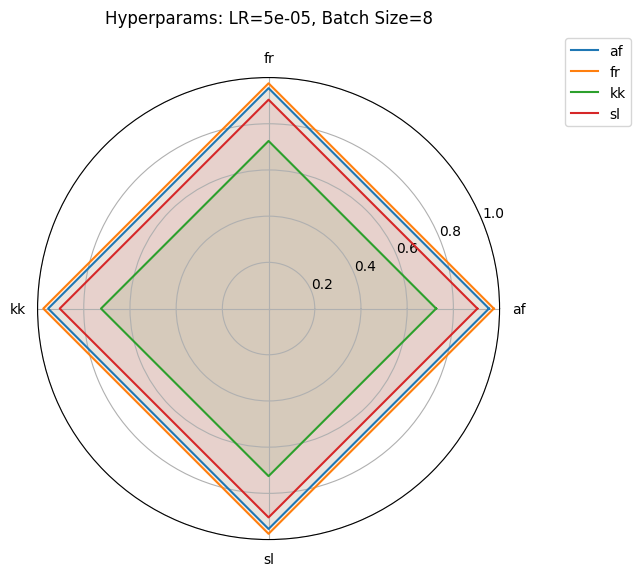

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_radar_for_hparams(df, lr, batch_size, metric="eval_accuracy"):
    # Filter dataframe for specific hyperparams
    subset = df[(df["lr"] == lr) & (df["batch_size"] == batch_size)]

    # Get unique training languages
    train_langs = subset["train_lang"].unique()
    test_langs = subset["test_lang"].unique()

    # Angles for radar chart
    num_vars = len(test_langs)
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # close the circle

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for train_lang in train_langs:
        # Select rows for this train_lang
        data = subset[subset["train_lang"] == train_lang]
        values = []
        for t in test_langs:
            row = data[data["test_lang"] == t]
            if not row.empty:
                values.append(row.iloc[0][metric])
            else:
                values.append(0.0)  # missing values
        values += values[:1]  # close the circle

        ax.plot(angles, values, label=f"{train_lang}")
        ax.fill(angles, values, alpha=0.1)

    # Setup labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(test_langs)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([str(v) for v in [0.2, 0.4, 0.6, 0.8, 1.0]])
    ax.set_ylim(0, 1)

    ax.set_title(f"Hyperparams: LR={lr}, Batch Size={batch_size}", y=1.1)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.show()


# Example usage for all (lr, batch_size) combinations
for (lr, bs), group in df.groupby(["lr", "batch_size"]):
    plot_radar_for_hparams(df, lr, bs, metric="eval_accuracy")


In [35]:
"""for lang in df["train_lang"].unique():
    subset = df[df["train_lang"] == lang]
    plt.figure(figsize=(8,6))
    for test_lang in subset["test_lang"].unique():
        plot_data = subset[subset["test_lang"] == test_lang]
        plt.plot(plot_data["lr"], plot_data["eval_accuracy"], marker="o", label=test_lang)
    plt.title(f"F1 vs Learning Rate (trained on {lang})")
    plt.xlabel("Learning Rate")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.show()"""


'for lang in df["train_lang"].unique():\n    subset = df[df["train_lang"] == lang]\n    plt.figure(figsize=(8,6))\n    for test_lang in subset["test_lang"].unique():\n        plot_data = subset[subset["test_lang"] == test_lang]\n        plt.plot(plot_data["lr"], plot_data["eval_accuracy"], marker="o", label=test_lang)\n    plt.title(f"F1 vs Learning Rate (trained on {lang})")\n    plt.xlabel("Learning Rate")\n    plt.ylabel("F1 Score")\n    plt.legend()\n    plt.show()'

In [ ]:
# FOR FRENCH ONLY

"""batch_size = 16
model_checkpoint = "bert-base-multilingual-cased"
max_label = max(label for sample in datasets["fr"]["train"] for label in sample["labels"] if label !=-100)
num_labels = max_label + 1 # Add 1 for the padding token
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

# Because sentences are of different lengths
data_collator = DataCollatorForTokenClassification(tokenizer)
training_args = TrainingArguments(
                        output_dir="bert-pos-tagger",
                        eval_strategy = "epoch",
                        learning_rate=2e-5,
                        per_device_train_batch_size=batch_size,
                        per_device_eval_batch_size=batch_size,
                        num_train_epochs=3,
                        weight_decay=0.01,
                        logging_dir='./logs',
                        logging_steps=10,
                        report_to="none",
                      )
trainer = Trainer(
          model=model,
          args=training_args,
          train_dataset=datasets["fr"]["train"], # the train set
          eval_dataset=datasets["fr"]["dev"], # the dev set
          compute_metrics=compute_metrics,
          data_collator=data_collator
        )
trainer.train()
free_memory(trainer,model)"""